# Finding trending issues on the SF311 dataset

Source of data: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6/data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'


## The time window to bucket samples
TIME_RANGE = '4H'

## File path
DATAPATH = "../SF_data/SF311_simplified.csv"


#### Turn a raw CSV file into a time series we can model using some utils from moda

In [2]:
from moda.dataprep.raw_to_ts import raw_to_ts
from moda.dataprep.ts_to_range import ts_to_range

def prep_data(datapath, time_range='24H', nrows=None, min_date=None, max_date=None, usecols=None):
    """
    Takes a raw data with timestamps (date column), categories (category column) and additional columns,
    and turns it into a ranged time-series: Group the original raw data by time interval (time_range) and category.
    Result is the number of samples per category in each time range.
    :param datapath: the path to the csv file
    :param time_range: the time_range according to which the data is grouped by
    :param nrows: limits the number of rows read from the csv
    :param min_date: filters out ranges prior to min_date
    :param max_date: filters out ranges after max_date

    :returns a pd.DataFrame with one value per time_range and category.
    This value is the number of samples within this range for a specific category
    """

    
    
    if nrows is None:
        raw = pd.read_csv(datapath, usecols=usecols)
    else:
        raw = pd.read_csv(datapath, usecols=usecols, nrows=nrows)

        
    raw = raw.rename(columns={'Opened': 'date', 'Category': 'category'})

    # Create a time series dataframe
    ts = raw_to_ts(raw, min_date=min_date, max_date=max_date)
    # Divide time series to ranges and categories
    ranged_ts = ts_to_range(ts, time_range=time_range)
    return ranged_ts



### Read a sample from the SF 311 data
Limiting the date range as this is a pretty big file

In [3]:
# This might take some time to load
#ranged_ts = prep_data(DATAPATH,time_range=TIME_RANGE,min_date='01-01-2016')
#ranged_ts.to_csv('SF_4H.csv')

ranged_ts = pd.read_csv("SF_4h.csv")
ranged_ts['date'] = pd.to_datetime(ranged_ts['date'])
ranged_ts=ranged_ts.set_index([pd.DatetimeIndex(ranged_ts['date']),'category']).drop(columns='date')

#### A time series in moda has a MultiIndex, comprised of the date and the category.


In [4]:
print("Dataset length: " + str(len(ranged_ts)))
print("Min date: " + str(ranged_ts.index.get_level_values('date').min()))
print("Max date: " + str(ranged_ts.index.get_level_values('date').max()))

print(ranged_ts.index.get_level_values('date').max() - ranged_ts.index.get_level_values('date').min())


Dataset length: 127834
Min date: 2016-01-01 00:00:00
Max date: 2018-08-25 00:00:00
967 days 00:00:00


In [5]:
ranged_ts.tail()

value
date                category                             
2018-08-24 20:00:00 Sign Repair                         4
2018-08-25 00:00:00 General Request - PUBLIC WORKS      1
                    MUNI Feedback                       1
                    Noise Report                        1
                    Sign Repair                         1

In [6]:
#Let's look which categories appear the most. We remove the index just for the EDA
flat = ranged_ts.reset_index()

#I'm using dfply because I like its functional-like syntax. This can also be done with plain pandas.
#!pip install dfply
from dfply import *

## Remove rare categories
min_values = 5000
min_days = 100

print("Original dataset contains {} categories.".format(len(flat['category'].unique())))


categories = flat >> group_by(X.category) >> \
    summarise(value = np.sum(X.value),duration_in_dataset = X.date.max()-X.date.min()) >> \
    ungroup() >> \
    mask(X.duration_in_dataset.dt.days > min_days) >> \
    mask(X.value > min_values) >> \
    arrange(X.value,ascending=False)



print("Filtered dataset contains {0} categories,\nafter filtering the small ones that existed less than {1} days or had {2} values of less.".
      format(len(categories),min_days,min_values))

categories.head()

Original dataset contains 89 categories.
Filtered dataset contains 26 categories,
after filtering the small ones that existed less than 100 days or had 5000 values of less.


,category,value,duration_in_dataset
85,Street and Sidewalk Cleaning,426797,965 days 00:00:00
71,Graffiti,193275,966 days 20:00:00
8,Encampments,116327,965 days 04:00:00
72,Homeless Concerns,93349,960 days 08:00:00
1,Abandoned Vehicle,78414,966 days 12:00:00


## Most discussed categories

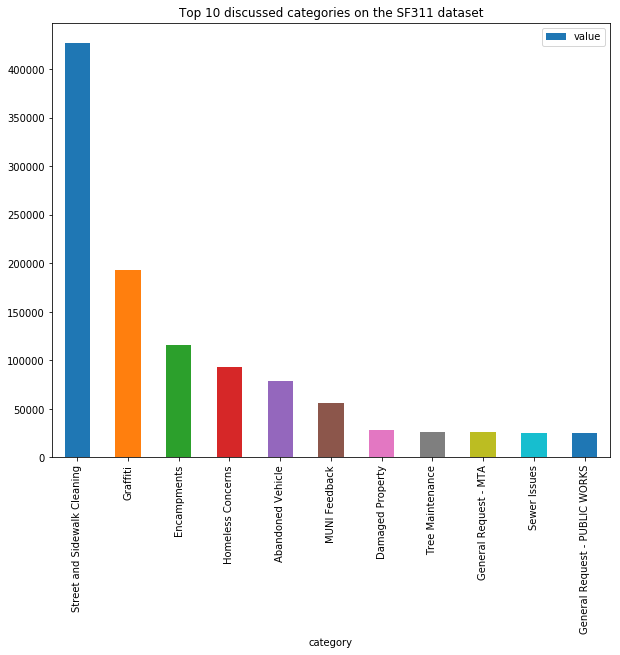

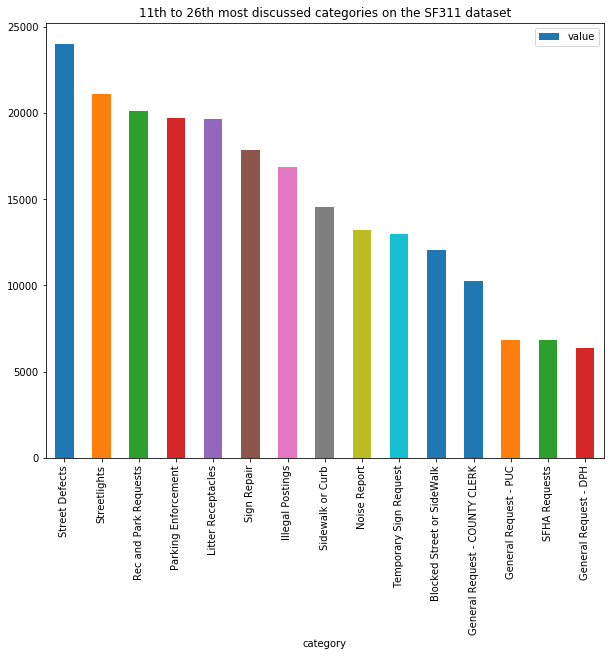

In [7]:
category_names = categories['category'].values
num_categories = len(categories)

major_category_threshold=11
major_categories = category_names[:major_category_threshold]
minor_categories = category_names[major_category_threshold:]


categories[categories['category'].isin(major_categories)].plot(kind='bar',x='category',y='value',title="Top "+str(major_category_threshold-1)+" discussed categories on the SF311 dataset",figsize=(10,8))
categories[categories['category'].isin(minor_categories)].plot(kind='bar',x='category',y='value',title=str(major_category_threshold)+"th to "+str(num_categories)+"th most discussed categories on the SF311 dataset",figsize=(10,8))

## Change in quantity over time

In [ ]:
## Calculate the number of values per category per year
categories_yearly = flat >> mutate(year = X.date.dt.year) >> group_by(X.category,X.year) >> \
    summarise(value_per_year = np.sum(X.value),
              duration_in_dataset = X.date.max()-X.date.min()) >>\
    ungroup() >> \
    mask(X.value_per_year > (min_values/12.0)) >> \
    arrange(X.value_per_year,ascending=False)

import seaborn as sns

major_cats_yearly = categories_yearly[categories_yearly['category'].isin(major_categories)]

g = sns.factorplot(x='category', y='value_per_year', hue='year', data=major_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the top "+str(major_category_threshold-1)+" categories")

Text(0.5,1,'Yearly number of incidents for the 11th to 26th categories')

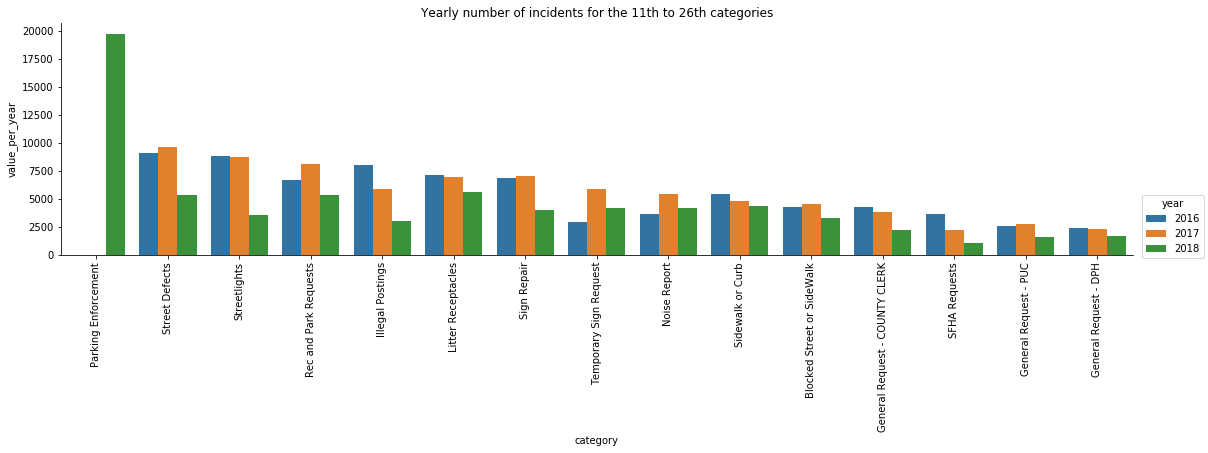

In [9]:
minor_cats_yearly = categories_yearly[categories_yearly['category'].isin(minor_categories)]

g = sns.factorplot(x='category', y='value_per_year', hue='year', data=minor_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the "+str(major_category_threshold)+"th to "+str(num_categories)+"th categories")

## Year correlation between categories

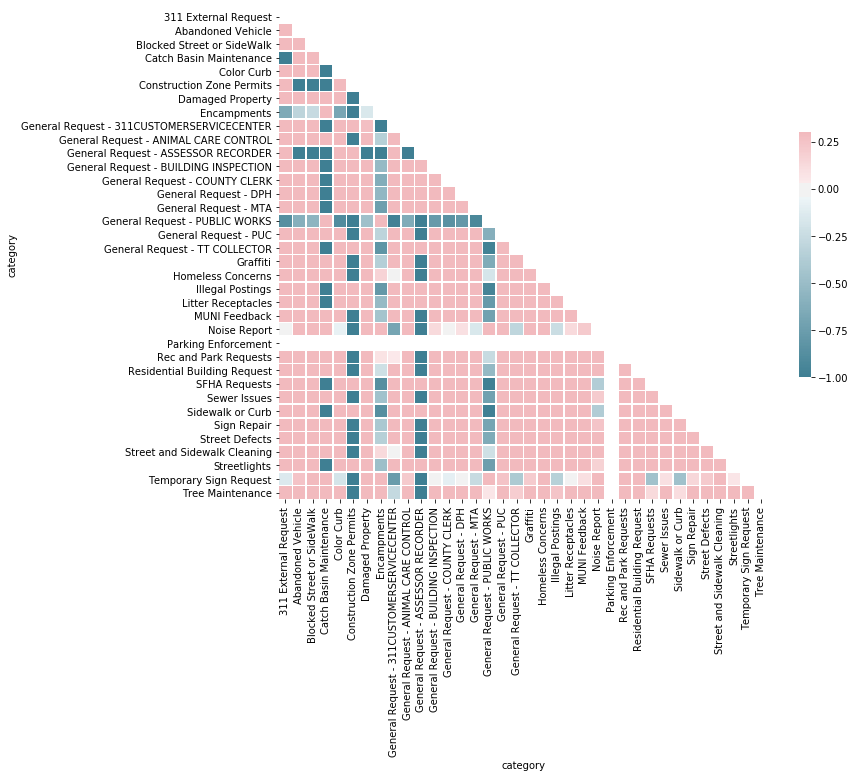

In [10]:
categories_yearly_pivot = categories_yearly.pivot("year", "category", "value_per_year")
categories_yearly_pivot.head()
corr = categories_yearly_pivot.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Time series inspection
### Selecting the biggest category, Street and Sidewalk Cleaning, just for inspection

In [11]:
street_cleaning = ranged_ts.loc[pd.IndexSlice[:, 'Street and Sidewalk Cleaning'], :].reset_index(level='category', drop=True)
street_cleaning.head()

,value
date,
2016-01-01 00:00:00,1
2016-01-01 04:00:00,6
2016-01-01 08:00:00,72
2016-01-01 12:00:00,54
2016-01-01 16:00:00,53


In [12]:
print(len(street_cleaning))
print(street_cleaning.index.get_level_values('date').min())
print(street_cleaning.index.get_level_values('date').max())

5759
2016-01-01 00:00:00
2018-08-23 00:00:00


### Time series plot

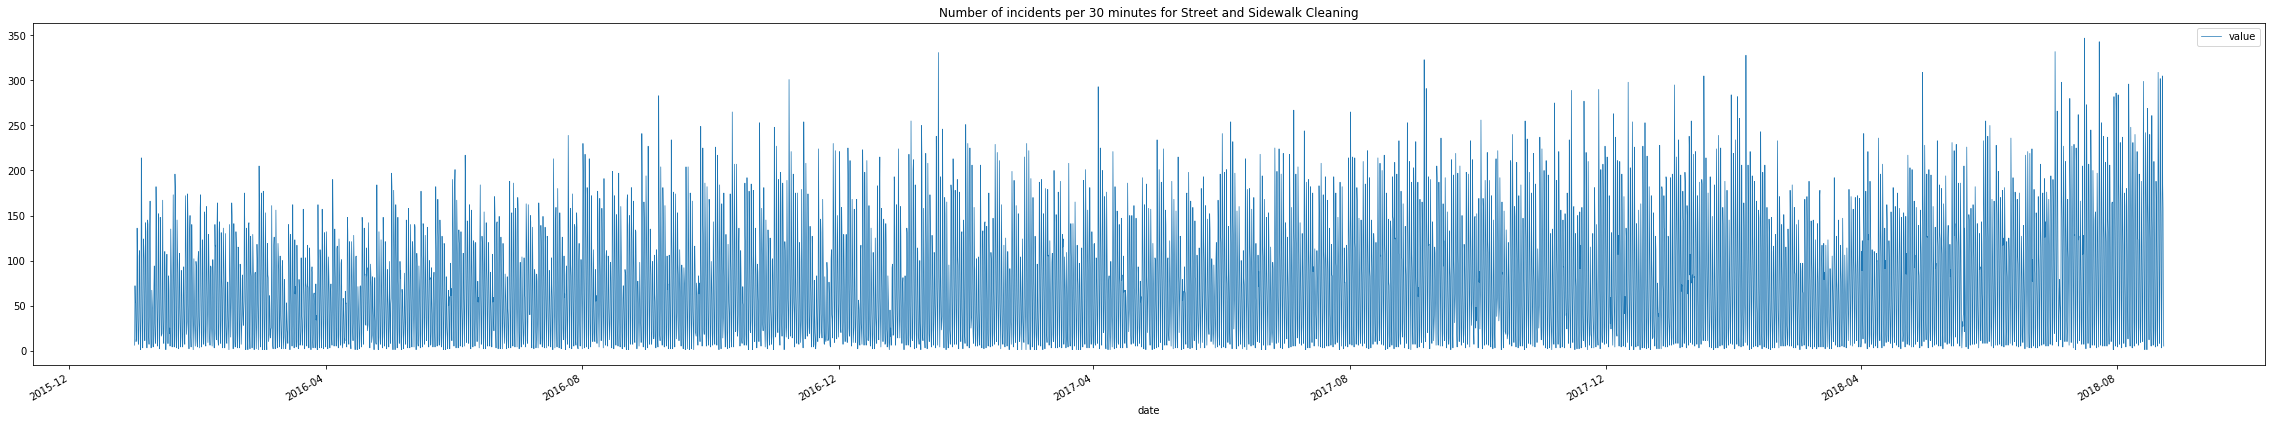

In [13]:
START = '2016-01-01'
END = '2019-01-01'
street_cleaning_flat = street_cleaning.reset_index()
street_cleaning_flat = street_cleaning_flat[(street_cleaning_flat['date'] > START) & (street_cleaning_flat['date']<=END)]
street_cleaning_flat.plot(kind='line',x='date',y='value',figsize=(40,7),linewidth=0.7, title = "Number of incidents per 30 minutes for Street and Sidewalk Cleaning")

# Forecasting the next time range value using LSTMs
#### Train/Test split

In [14]:
train_percent = 70
dates = street_cleaning_flat['date']
num_dates = len(dates)

train = street_cleaning_flat[:int(num_dates * train_percent / 100)]
test = street_cleaning_flat[int(num_dates * train_percent / 100):]

train_original = train.copy()
test_original = test.copy()

print("Training set length = {0}, Test set length = {1}".format(len(train),len(test)))

Training set length = 4030, Test set length = 1728


#### Pad train and test with zeros on dates when zero events occured

In [15]:
train = train.set_index('date').resample(TIME_RANGE, convention='start').asfreq().fillna(0)
test = test.set_index('date').resample(TIME_RANGE, convention='start').asfreq().fillna(0)
print("Training set length = {0}, Test set length = {1}".format(len(train),len(test)))

Training set length = 4061, Test set length = 1729


#### Scale values

In [16]:
from sklearn.preprocessing import MinMaxScaler


## Using different scalers for train and test
scaler = MinMaxScaler(feature_range=(-1,1))

scaled_values_train = scaler.fit_transform(train['value'].values.reshape(-1, 1))
train_scaled = pd.DataFrame(index = train.index)
train_scaled['value'] = scaled_values_train

scaled_values_test = scaler.transform(test['value'].values.reshape(-1, 1))
test_scaled = pd.DataFrame(index = test.index)
test_scaled['value'] = scaled_values_test

train_scaled.head()

,value
date,
2016-01-01 04:00:00,-0.963746
2016-01-01 08:00:00,-0.564955
2016-01-01 12:00:00,-0.673716
2016-01-01 16:00:00,-0.679758
2016-01-01 20:00:00,-0.939577


In [17]:
# Prep series for modeling by creating a data frame where each row is a sliding window in time.

window_size = int((24/4.0)*21)
print("Window size = " + str(window_size))
# Train
train_samples = train_scaled.copy()
for i in range(window_size):
    train_scaled = pd.concat([train_scaled,train_samples.shift(-(i+1))],axis=1)
train_scaled = train_scaled.dropna(axis=0)


# Test
test_samples = test_scaled.copy()
for i in range(window_size):
    test_scaled = pd.concat([test_scaled,test_samples.shift(-(i+1))],axis=1)
test_scaled = test_scaled.dropna(axis=0)

print("Train length={0}, Test length={1}".format(len(train_scaled),len(test_scaled)))

Window size = 126
Train length=3935, Test length=1603


In [18]:
train_scaled.head()

,value,value,value,value,value,value,value,value,value,value,...,value,value,value,value,value,value,value,value,value,value
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 04:00:00,-0.963746,-0.564955,-0.673716,-0.679758,-0.939577,-0.915408,-0.794562,-0.178248,-0.413897,-0.764350,...,-0.528701,-0.897281,-0.981873,-0.709970,-0.123867,-0.329305,-0.480363,-0.897281,-0.987915,-0.818731
2016-01-01 08:00:00,-0.564955,-0.673716,-0.679758,-0.939577,-0.915408,-0.794562,-0.178248,-0.413897,-0.764350,-0.933535,...,-0.897281,-0.981873,-0.709970,-0.123867,-0.329305,-0.480363,-0.897281,-0.987915,-0.818731,-0.419940
2016-01-01 12:00:00,-0.673716,-0.679758,-0.939577,-0.915408,-0.794562,-0.178248,-0.413897,-0.764350,-0.933535,-0.957704,...,-0.981873,-0.709970,-0.123867,-0.329305,-0.480363,-0.897281,-0.987915,-0.818731,-0.419940,-0.347432
2016-01-01 16:00:00,-0.679758,-0.939577,-0.915408,-0.794562,-0.178248,-0.413897,-0.764350,-0.933535,-0.957704,-0.788520,...,-0.709970,-0.123867,-0.329305,-0.480363,-0.897281,-0.987915,-0.818731,-0.419940,-0.347432,-0.716012
2016-01-01 20:00:00,-0.939577,-0.915408,-0.794562,-0.178248,-0.413897,-0.764350,-0.933535,-0.957704,-0.788520,-0.365559,...,-0.123867,-0.329305,-0.480363,-0.897281,-0.987915,-0.818731,-0.419940,-0.347432,-0.716012,-0.854985


In [19]:
test_scaled.head()

,value,value,value,value,value,value,value,value,value,value,...,value,value,value,value,value,value,value,value,value,value
date,,,,,,,,,,,,,,,,,,,,,
2017-11-08 00:00:00,-0.957704,-0.504532,0.335347,0.009063,-0.601208,-0.891239,-0.981873,-0.577039,-0.057402,-0.305136,...,0.093656,-0.407855,-0.734139,-0.987915,-0.709970,0.214502,-0.051360,-0.480363,-0.891239,-0.945619
2017-11-08 04:00:00,-0.504532,0.335347,0.009063,-0.601208,-0.891239,-0.981873,-0.577039,-0.057402,-0.305136,-0.413897,...,-0.407855,-0.734139,-0.987915,-0.709970,0.214502,-0.051360,-0.480363,-0.891239,-0.945619,-0.613293
2017-11-08 08:00:00,0.335347,0.009063,-0.601208,-0.891239,-0.981873,-0.577039,-0.057402,-0.305136,-0.413897,-0.867069,...,-0.734139,-0.987915,-0.709970,0.214502,-0.051360,-0.480363,-0.891239,-0.945619,-0.613293,0.250755
2017-11-08 12:00:00,0.009063,-0.601208,-0.891239,-0.981873,-0.577039,-0.057402,-0.305136,-0.413897,-0.867069,-0.975831,...,-0.987915,-0.709970,0.214502,-0.051360,-0.480363,-0.891239,-0.945619,-0.613293,0.250755,0.057402
2017-11-08 16:00:00,-0.601208,-0.891239,-0.981873,-0.577039,-0.057402,-0.305136,-0.413897,-0.867069,-0.975831,-0.824773,...,-0.709970,0.214502,-0.051360,-0.480363,-0.891239,-0.945619,-0.613293,0.250755,0.057402,-0.625378


### Plot train and test time series

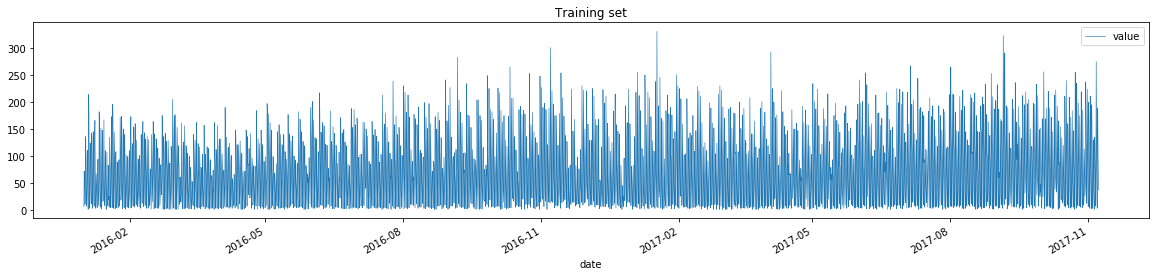

In [20]:
train_original.reset_index().plot(kind='line',x='date',y='value',figsize=(20,4),linewidth=0.6, title = "Training set")

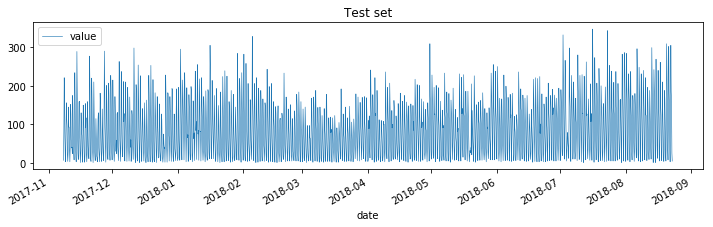

In [21]:
test_original.reset_index().plot(kind='line',x='date',y='value',figsize=(12,3),linewidth=0.6, title = "Test set")

In [22]:
train_X = train_scaled.iloc[:,:-1].values # train_X data is the window until time t
train_y = train_scaled.iloc[:,-1].values # train_y is the value at t+1
test_X = test_scaled.iloc[:,:-1].values # same for test
test_y = test_scaled.iloc[:,-1].values

test_dates = test_scaled.index

train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

print("train_X dim={0}, train_y dim={1}, test_X dim={2}, test_y dim={3}".format(train_X.shape,train_y.shape,test_X.shape,test_y.shape))

train_X dim=(3935, 126, 1), train_y dim=(3935,), test_X dim=(1603, 126, 1), test_y dim=(1603,)


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 126, 126)          64512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               130560    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 195,201
Trainable params: 195,201
Non-trainable params: 0
_________________________________________________________________
Train on 3541 samples, validate on 394 samples
Epoch 1/40
3541/3541 [==============================] - 16s 4ms/step - loss: 0.2242 - val

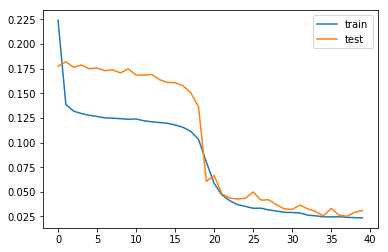

MSE=0.0437061915725478


In [23]:
from keras.models import Sequential        
from keras.layers import LSTM, Dense, Activation,Dropout
from keras.callbacks import EarlyStopping
import time

model = Sequential()
model.add(LSTM(input_shape=(window_size, 1),units=window_size, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()


start = time.time()
history = model.fit(train_X,train_y,batch_size=400,
                    epochs=40,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(patience=4)])
print("> Compilation Time : ", time.time() - start)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Doing a prediction on all the test data at once
preds = model.predict(test_X)

from sklearn.metrics import mean_squared_error
print("MSE="+str(mean_squared_error(test_y,preds)))

#### Real vs. predicted for 500 samples

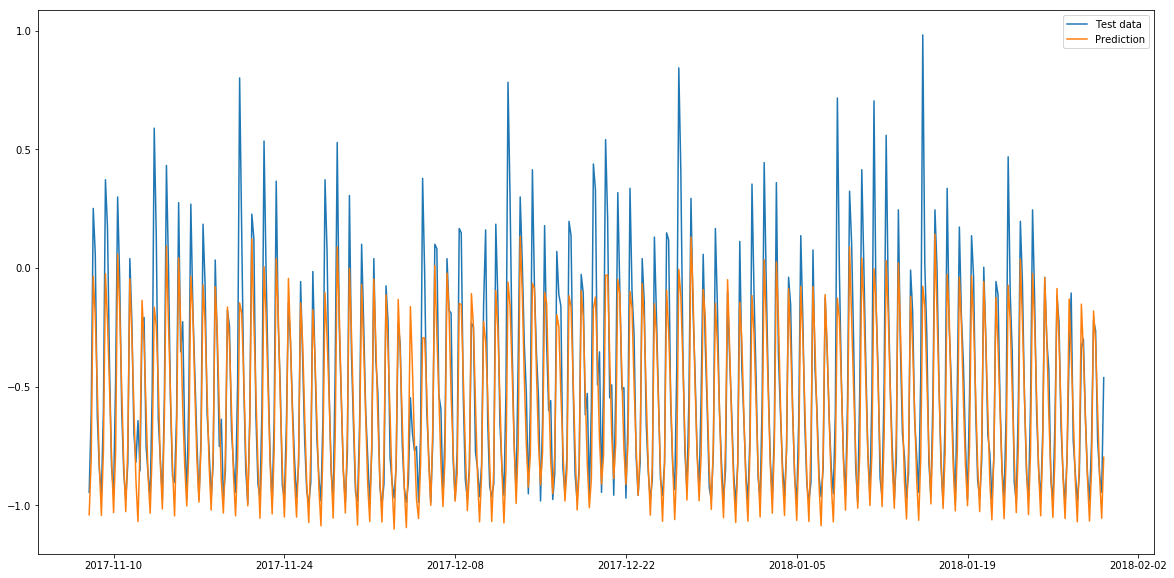

In [28]:
plt.figure(figsize=(20,10))
plt.plot(test_dates[:500],test_y[:500],label='Test data')
plt.plot(test_dates[:500],preds[:500],label='Prediction')
plt.legend()

### Anomaly detection by analyzing the difference between the forecasted sample and the real sample

In [29]:
results = pd.DataFrame({"date":test_dates,"prediction" : preds.squeeze(),"actual" : test_y,"diff" : test_y - preds.squeeze()})
results['diff_rolling_std']=results['diff'].rolling(window=7*24*2, min_periods=10).std() # naive version where we look at the standard deviation of the difference between predicted and actual in a previous window.
results['anomaly_3sd'] = np.where(results['diff'] > 3*results['diff_rolling_std'],1,0)
results['anomaly_4sd'] = np.where(results['diff'] > 4*results['diff_rolling_std'],1,0)
results['anomaly_5sd'] = np.where(results['diff'] > 5*results['diff_rolling_std'],1,0)
results['anomaly_6sd'] = np.where(results['diff'] > 6*results['diff_rolling_std'],1,0)

results.tail()


,date,prediction,actual,diff,diff_rolling_std,anomaly_3sd,anomaly_4sd,anomaly_5sd,anomaly_6sd
1598,2018-08-01 08:00:00,0.007579,0.842900,0.835321,0.240373,1,0,0,0
1599,2018-08-01 12:00:00,-0.027337,0.117825,0.145162,0.239978,0,0,0,0
1600,2018-08-01 16:00:00,-0.379143,-0.045317,0.333826,0.239882,0,0,0,0
1601,2018-08-01 20:00:00,-0.667431,-0.842900,-0.175470,0.240163,0,0,0,0
1602,2018-08-02 00:00:00,-0.920048,-0.969789,-0.049741,0.240287,0,0,0,0


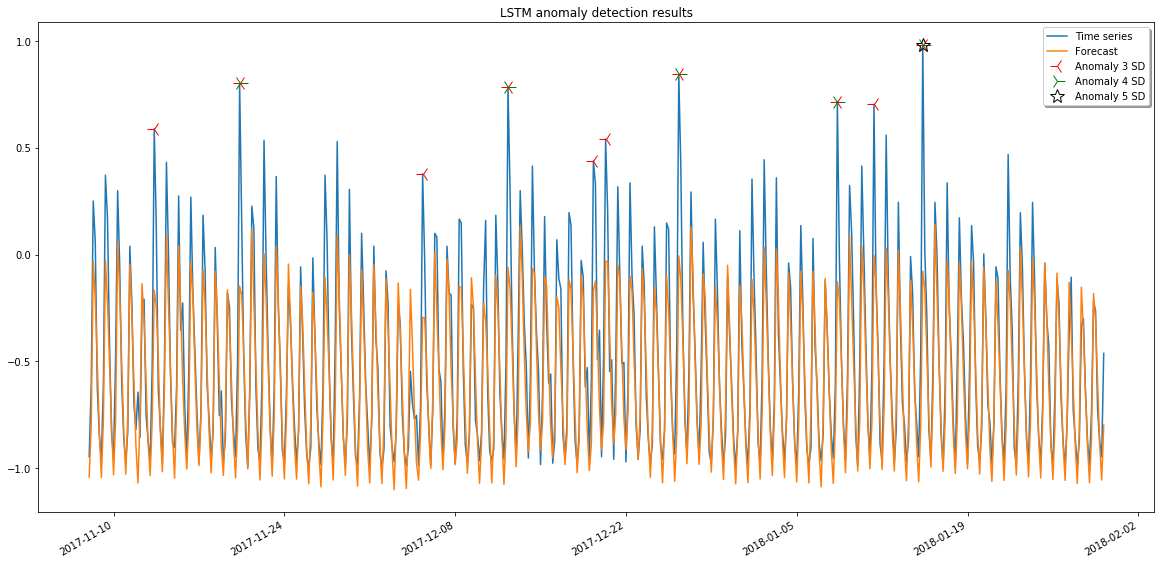

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.autofmt_xdate()


plot_data_window = range(500)

results_to_plot = results.iloc[plot_data_window]

dates = results_to_plot['date']


ax.plot(results_to_plot.date, results_to_plot.actual, label='Time series')
ax.plot(results_to_plot.date, results_to_plot.prediction, label='Forecast')



mask_3sd = (~np.isnan(results_to_plot.anomaly_3sd)) & (results_to_plot.anomaly_3sd != 0)
ax.plot_date(results_to_plot.date[mask_3sd], results_to_plot.actual[mask_3sd], marker='3', markersize=15, color='r', label='Anomaly 3 SD')

mask_4sd = (~np.isnan(results_to_plot.anomaly_4sd)) & (results_to_plot.anomaly_4sd != 0)
ax.plot_date(results_to_plot.date[mask_4sd], results_to_plot.actual[mask_4sd], marker='4', markersize=15,color='g', label='Anomaly 4 SD')

mask_5sd = (~np.isnan(results_to_plot.anomaly_5sd)) & (results_to_plot.anomaly_5sd != 0)
ax.plot_date(results_to_plot.date[mask_5sd], results_to_plot.actual[mask_5sd], marker='*', markersize=15, color='k',fillstyle="none", label='Anomaly 5 SD')

plt.title("LSTM anomaly detection results")
ax.legend(shadow=True, fancybox=True)
